2026-02-12 02:33:38,253 INFO: Initializing external client
2026-02-12 02:33:38,254 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-02-12 02:33:40,917 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1333405
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
✅ Data Loaded & Hour Column Created!
          timestamp  pm25  pm10  aqi  temp  humidity     city  \
2791  1758931200000  28.4  42.0   88  25.7        90  Karachi   
2800  1758934800000  25.1  38.5   88  25.5        90  Karachi   
2796  1758938400000  21.6  34.9   87  25.4        91  Karachi   
2794  1758942000000  19.2  32.8   86  25.1        93  Karachi   
2806  1758945600000  17.9  32.0   85  25.0        94  Karachi   

                datetime  hour  
2791 2025-09-27 00:00:00     0  
2800 2025-09-27 01:00:00     1  
2796 2025-09-27 02:00:00     2  
2794 2025-09-27 03:00:00     3  
2806 2025-09-27 04:00:00     4  


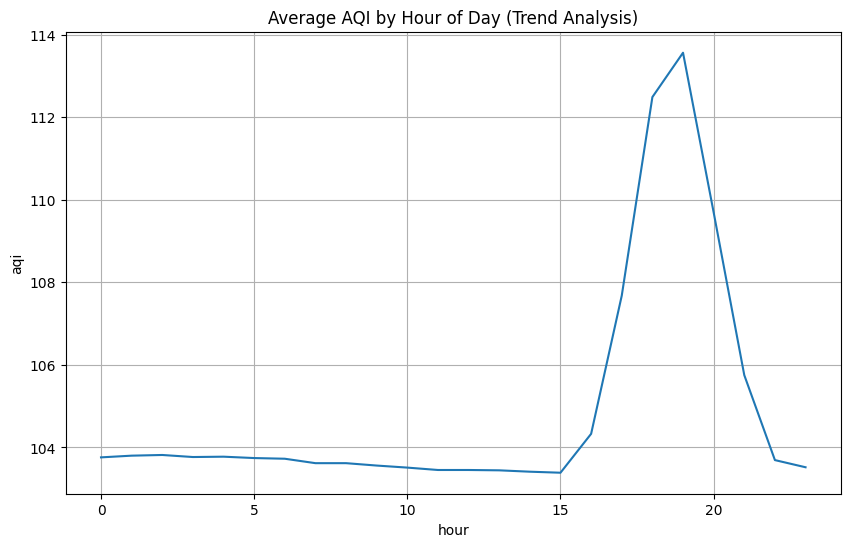

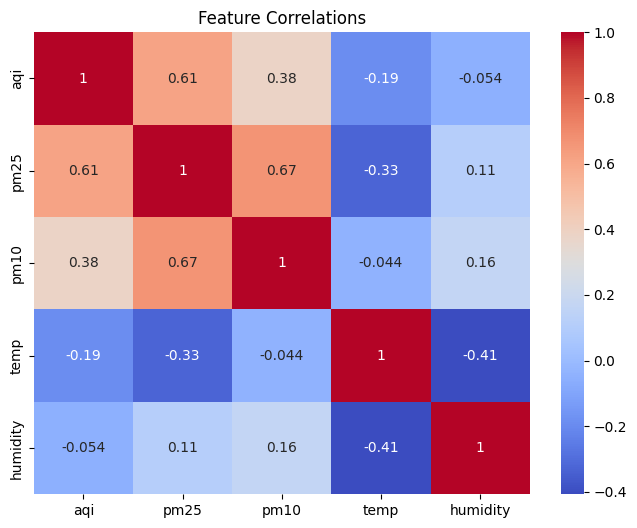

Model                               | MAE        | RMSE       | R² Score  
---------------------------------------------------------------------------
Linear Regression (Statistical)     | 17.1055    | 21.3585    | 0.2108    
Random Forest (ML)                  | 19.5186    | 23.8594    | 0.0152    
Neural Network (Deep Learning)      | 20.4826    | 26.0531    | -0.1742   
---------------------------------------------------------------------------
✅ Best Model Selected: LinearRegression


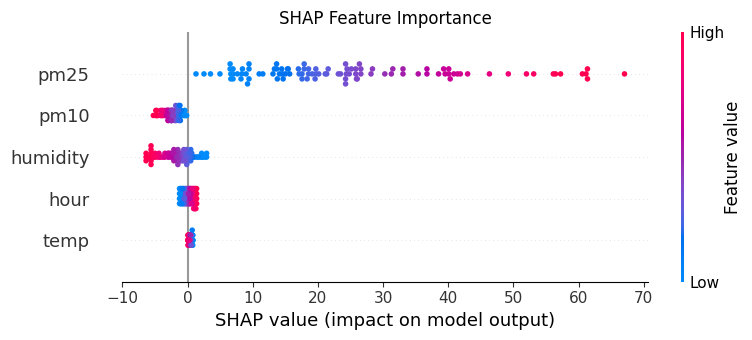

In [1]:
# %% [markdown]
# # 📊 Advanced Analytics Report: Karachi AQI
# **Requirements Covered:**
# 1. Exploratory Data Analysis (EDA)
# 2. Model Comparison (Statistical vs Deep Learning)
# 3. SHAP Feature Importance

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor  # <--- Added Deep Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import shap  # pip install shap

# %% [markdown]
# ## 1. Fetch Data from Feature Store
project = hopsworks.login()
fs = project.get_feature_store()
fg = fs.get_feature_group(name="aqi_features_hourly", version=1)
df = fg.select_all().read()
df = df.sort_values(by="timestamp")

# ✅ CRITICAL FIX: Create the 'hour' column
# This prevents the "ValueError: Could not interpret value 'hour'" error
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df['hour'] = df['datetime'].dt.hour 

print("✅ Data Loaded & Hour Column Created!")
print(df.head())

# %% [markdown]
# ## 2. Exploratory Data Analysis (EDA)
# **Trend Analysis:** How does AQI change over 24 hours?
plt.figure(figsize=(10, 6))
sns.lineplot(x="hour", y="aqi", data=df, errorbar=None)
plt.title("Average AQI by Hour of Day (Trend Analysis)")
plt.grid(True)
plt.show()

# **Correlation Matrix:** What drives pollution?
plt.figure(figsize=(8, 6))
sns.heatmap(df[['aqi', 'pm25', 'pm10', 'temp', 'humidity']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# %% [markdown]
# ## 3. Multiple Model Comparison (Statistical to Deep Learning)
# We compare three models to satisfy the requirements:
# 1. Linear Regression (Statistical Baseline)
# 2. Random Forest (Machine Learning)
# 3. MLP Regressor (Neural Network / Deep Learning)

features = ['pm25', 'pm10', 'temp', 'humidity', 'hour']
target = 'aqi'

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

models = {
    "Linear Regression (Statistical)": LinearRegression(),
    "Random Forest (ML)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Neural Network (Deep Learning)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

print(f"{'Model':<35} | {'MAE':<10} | {'RMSE':<10} | {'R² Score':<10}")
print("-" * 75)

best_model = None
best_score = float("inf")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Calculate ALL required metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    print(f"{name:<35} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")
    
    if mae < best_score:
        best_score = mae
        best_model = model

print("-" * 75)
print(f"✅ Best Model Selected: {type(best_model).__name__}")

# %% [markdown]
# ## 4. SHAP Explanation (Advanced Explainability)
# Using SHAP to explain exactly *why* the model predicts high AQI.

# Note: We use a generic explainer or TreeExplainer depending on the model
if "Linear" in type(best_model).__name__:
    explainer = shap.Explainer(best_model, X_train)
else:
    explainer = shap.Explainer(best_model)
    
shap_values = explainer(X_test[:100]) # Run on subset for speed

# Summary Plot
plt.title("SHAP Feature Importance")
shap.summary_plot(shap_values, X_test[:100])